# ~ 環境準備

In [ ]:
# 安裝 MedMNIST 資料集
!pip install -q --upgrade git+https://github.com/MedMNIST/MedMNIST.git
import medmnist
from medmnist import INFO
from medmnist.__main__ import download
# download('.')  # 下載所有資料到工作資料夾中(很慢)
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 699.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
# import packages
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# tensorflow.keras
import tensorflow as tf
print("Tensorflow version =", tf.__version__)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import initializers, regularizers, optimizers, layers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K

Tensorflow version = 2.11.0


# 準備資料集

In [ ]:
#@title 下載並解壓縮 MedMNIST 資料
# Download data and unzip the file from google drive share-link :
# https://drive.google.com/file/d/1MzmUKnyRs3_KcYuuyKpgKd6DZ4vVvKmx/view?usp=sharing
!pip install -q --upgrade --no-cache-dir gdown
import gdown
url = "https://drive.google.com/uc?id=1MzmUKnyRs3_KcYuuyKpgKd6DZ4vVvKmx"
gdown.download(url, "MedNIST.zip", quiet=False)
!unzip -n -q 'MedNIST.zip' -d '.'
print("... done")

Downloading...
From: https://drive.google.com/uc?id=1MzmUKnyRs3_KcYuuyKpgKd6DZ4vVvKmx
To: /content/MedNIST.zip
100%|██████████| 689M/689M [00:05<00:00, 121MB/s]


... done


In [ ]:
!python -m medmnist available

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


In [ ]:
# 獲得資料集訊息
data_name = 'pathmnist'  # <- 資料集名稱

info_dict = INFO[data_name]
task = info_dict['task']
n_channels = info_dict['n_channels']
n_classes = len(info_dict['label'])
info_dict

{'python_class': 'PathMNIST',
 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',
 'url': 'https://zenodo.org/record/6496656/files/pathmnist.npz?download=1',
 'MD5': 'a8b06965200029087d5bd730944a56c1',
 'task': 'multi-class',
 'label': {'0': 'adipose',
  '1': 'background',
  '2': 'debris',
  '3': 'lymphocytes',
  '4': 'mucus',
  '5': 'smooth muscle',
  '6': 'normal colon mucosa',
  '7': 'cancer-associated stroma',
  '8': '

In [ ]:
# 一個 npz 裏面包含了多個 npy(numpy array 的存檔)
# open a npz file of MedNIST
data = np.load(f'{data_name}.npz')  # 選一個資料集項目
npy_file_lst = data.files
for npy in npy_file_lst:
    print(npy)
    # print(data[npy])

train_images
val_images
test_images
train_labels
val_labels
test_labels


In [ ]:
# 準備 image 和 label 的 numpy array
# images
train_images_arr = data['train_images']
valid_images_arr = data['val_images']
test_images_arr = data['test_images']
# labels
train_labels_arr = data['train_labels']
valid_labels_arr = data['val_labels']
test_labels_arr = data['test_labels']

print("train_images_arr:", train_images_arr.shape, train_images_arr.dtype, "\ttrain_labels_arr:", train_labels_arr.shape, train_labels_arr.dtype)
print("valid_images_arr:", valid_images_arr.shape, valid_images_arr.dtype, "\tvalid_labels_arr:", valid_labels_arr.shape, valid_labels_arr.dtype)
print("test_images_arr:", test_images_arr.shape, test_images_arr.dtype, "\ttest_labels_arr:", test_labels_arr.shape, test_labels_arr.dtype)

train_images_arr: (89996, 28, 28, 3) uint8 	train_labels_arr: (89996, 1) uint8
valid_images_arr: (10004, 28, 28, 3) uint8 	valid_labels_arr: (10004, 1) uint8
test_images_arr: (7180, 28, 28, 3) uint8 	test_labels_arr: (7180, 1) uint8


## 標記分析

In [ ]:
all_labels = np.concatenate([train_labels_arr, valid_labels_arr, test_labels_arr], axis=0)
print("有這些標記:", np.unique(all_labels))

有這些標記: [0 1 2 3 4 5 6 7 8]


In [ ]:
# 各標記的數量



In [ ]:
# 各標記數量 畫成 圓餅圖(pie chart)



## 資料集準備

In [ ]:
# 處理 label 為 one-hot encoding (獨熱編碼)
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
# PathMNIST	是9個分類
CLASSES = list(info_dict['label'].values())
print("CLASSES =", CLASSES)
train_labels_onehot =  to_categorical(train_labels_arr, num_classes=len(CLASSES), dtype='uint8')
valid_labels_onehot =  to_categorical(valid_labels_arr, num_classes=len(CLASSES), dtype='uint8')
test_labels_onehot =  to_categorical(test_labels_arr, num_classes=len(CLASSES), dtype='uint8')

print("原本的標註長這樣:", train_labels_arr[:10].tolist())
print("獨熱的標註長這樣:", train_labels_onehot[:10].tolist())
print("train_labels_onehot:", train_labels_onehot.shape, train_labels_onehot.dtype)
print("valid_labels_onehot:", valid_labels_onehot.shape, valid_labels_onehot.dtype)
print("test_labels_onehot:", test_labels_onehot.shape, test_labels_onehot.dtype)

CLASSES = ['adipose', 'background', 'debris', 'lymphocytes', 'mucus', 'smooth muscle', 'normal colon mucosa', 'cancer-associated stroma', 'colorectal adenocarcinoma epithelium']
原本的標註長這樣: [[0], [4], [7], [5], [5], [8], [3], [3], [5], [2]]
獨熱的標註長這樣: [[1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0]]
train_labels_onehot: (89996, 9) uint8
valid_labels_onehot: (10004, 9) uint8
test_labels_onehot: (7180, 9) uint8


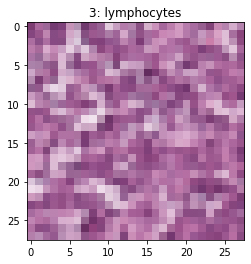

In [ ]:
# 隨機顯示一張圖片 和 它的標註
i = np.random.randint(100)  # 隨機一個整數 0-100
plt.imshow(train_images_arr[i])
plt.title(f"{train_labels_arr[i,0]}: {CLASSES[train_labels_arr[i,0]]}")
plt.show()

# 模型 model design

In [ ]:
# 利用 "Sequential" 把每層 layer 疊起來
# input 大小為 28 x 28 x 3

# 最後的 Dense(9) 且 activation 用 softmax
# 代表最後 output 為 9 個 class（0~8）的機率

model = Sequential([
    layers.Flatten(input_shape=(28, 28, n_channels)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

# model每層定義好後需要經過compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# 看看設計架構
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 128)               301184    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 302,345
Trainable params: 302,345
Non-trainable params: 0
_________________________________________________________________


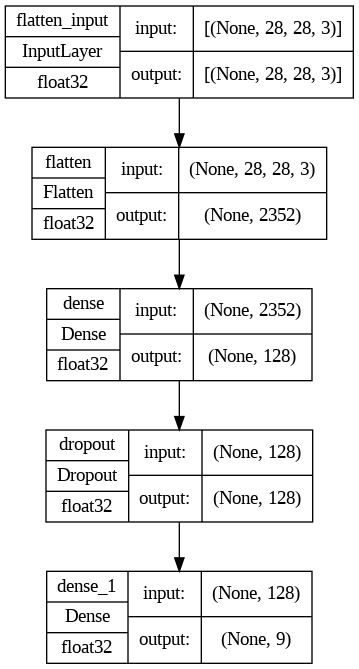

In [ ]:
# 看看設計架構
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)

# 訓練 training

In [ ]:
# training  https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
BATCH_SIZE = 32
EPOCH = 5

history = model.fit(train_images_arr, train_labels_onehot,  # < 訓練集
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCH, 
                    validation_data=(valid_images_arr, valid_labels_onehot), 
                    )

Epoch 1/5
2813/2813 [==============================] - 14s 3ms/step - loss: 4.9273 - accuracy: 0.1415 - val_loss: 2.1851 - val_accuracy: 0.1431
Epoch 2/5
2813/2813 [==============================] - 10s 3ms/step - loss: 2.1849 - accuracy: 0.1432 - val_loss: 2.1850 - val_accuracy: 0.1431
Epoch 3/5
2813/2813 [==============================] - 9s 3ms/step - loss: 2.1849 - accuracy: 0.1432 - val_loss: 2.1850 - val_accuracy: 0.1431
Epoch 4/5
2813/2813 [==============================] - 9s 3ms/step - loss: 2.1849 - accuracy: 0.1427 - val_loss: 2.1850 - val_accuracy: 0.1431
Epoch 5/5
2813/2813 [==============================] - 9s 3ms/step - loss: 2.1849 - accuracy: 0.1432 - val_loss: 2.1850 - val_accuracy: 0.1431


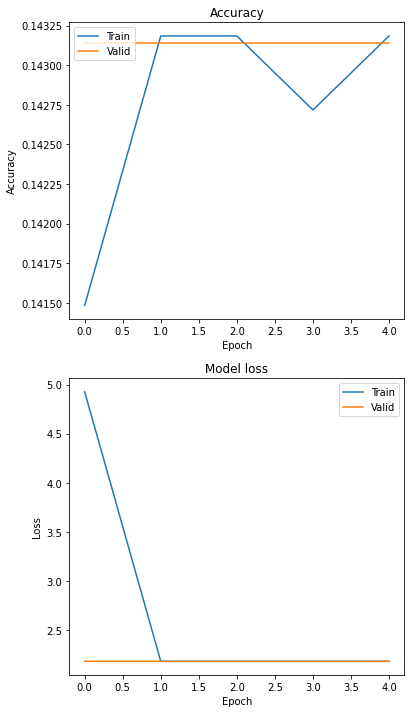

In [ ]:
#@title 訓練曲線
# Training history visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Accuracy')
ax1.set(ylabel='Accuracy', xlabel='Epoch')
ax1.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(ylabel='Loss', xlabel='Epoch')
ax2.legend(['Train', 'Valid'], loc='upper right')

plt.show()

In [ ]:
#@title 儲存模型 save model
h5_file_path = "Flatten_D128_O2_D9_ep300.h5"
model.save(h5_file_path)

# 評估 Evaluation

In [ ]:
model.evaluate(valid_images_arr, valid_labels_onehot, return_dict=True, verbose=2)

# 預測 predict

In [ ]:
#@title 讀取模型 restore model
h5_file_path = "Flatten_D128_O2_D9_ep300.h5"
model = load_model(h5_file_path)

In [ ]:
y_pred = model.predict(test_images_arr, 
                       batch_size=BATCH_SIZE, 
                       verbose=1)
print("y_pred:", y_pred.shape, y_pred.dtype)

In [ ]:
# 轉換為預測類別
y_pred_class = np.argmax(y_pred, axis=1)
print("y_pred_class:", y_pred_class.shape, y_pred_class.dtype)

In [ ]:
# 隨機選一張 測試圖片 並 顯示 原始與預測的結果
i = np.random.randint(test_images_arr.shape[0])

# plot
plt.imshow(test_images_arr[i])
plt.title(f"GroundTrue:{test_labels_arr[i,0]} {CLASSES[test_labels_arr[i,0]]}  \n  Predict:{y_pred_class[i]} {CLASSES[y_pred_class[i]]}")
plt.show()